In [1]:
import jax
import jax.numpy as jnp
import jax_dataloader as jdl

from typing import Any, Callable, final
from typing_extensions import override

import numpyro.distributions as numpyro_dist

from cryojax.inference import distributions as dist
from cryojax.data import RelionParticleParameterDataset, RelionParticleStackDataset, write_starfile_with_particle_parameters, write_simulated_image_stack_from_starfile

import cryo_reweighting.optimization as optimization

import src.ensemble_sim as sim
import src.log_likelihood as ll
import src.utils as utils

import matplotlib.pyplot as plt
import os


/mnt/home/levans/venvs/ensemble_sim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create list of pdb files for simulating images from

In [2]:
path_to_models="data/calhm2_models/"
model_fnames = []
for model_fname in sorted(os.listdir(path_to_models)):
    model_fnames.append(model_fname)


# Define a weight distribution on the pdb files

In [3]:
## Define density that volumes are resampled from
true_weights = jnp.array([0.2, 0.8])
jnp.save("true_weights.npy", true_weights)

# Define a config file for image simulation
### NOTE: for illustrative purposes, the SNR below is set VERY low

In [4]:
# REPLACE with your own favorite directory that can have big files dropped in it
base_directory = "/mnt/home/levans/ceph/cryojax_particles/calhm2_images"
#base_directory = "My favorite directory"

# Adjust names as needed, for saving configs and big image files
path_to_starfile = base_directory + "my_starfile.star"
path_to_images = base_directory

#### Bare bones config for this notebook
## Things that may need to be adjusted:
##   number of images, noise_snr
## Everything else, unlikely
config = {
"number_of_images": 100,
"snr": 0.001,
"weights_models": true_weights,
"models_fnames": model_fnames, 
"path_to_models": path_to_models, 
"path_to_starfile": path_to_starfile,
"path_to_images": path_to_images,
"box_size": 128,
"rng_seed": 0,
"pixel_size": 1.6,
}

In [6]:
# Generate RNG keys
number_of_images = config["number_of_images"]
keys = jax.random.split(jax.random.PRNGKey(0), number_of_images)

# make instrument confg
instrument_config = utils.instrument_config_from_params(config)

# make parameters
particle_parameters = sim.make_particle_parameters(keys, instrument_config)

# generate the a "starfile", I/O paradigm for software Relion
write_starfile_with_particle_parameters(
    particle_parameters,
    config["path_to_starfile"],
    mrc_batch_size=config["number_of_images"],
    overwrite=True,
)
parameter_reader = RelionParticleParameterDataset(
    path_to_starfile=config["path_to_starfile"],
    path_to_relion_project=config["path_to_images"],
)

# Create static image formation stuff: potentials, potential integrator
imaging_args = utils.build_image_formation_stuff(config)



# Estimate the variance of the images
here, we are simulating just a few clean images (10), and computing the average variance of clean images from them

In [7]:
var_est_seed = 0
key_var_est = jax.random.key(var_est_seed)
signal_variance = sim.estimate_signal_variance(
    key_var_est,
    n_images_for_estimation=10,
    mask_radius=config["box_size"]// 3,
    instrument_config=instrument_config,
    args=(
        imaging_args["potentials"],
        imaging_args["potential_integrator"],
        config["weights_models"],
        1.0,
    ),  # the last argument is the variance, not needed for this
)

# Simulate a dataset!

In [8]:
# Prep prameters for writing: noise variance, and imaging args
noise_variance = signal_variance / config["snr"]
constant_args = (imaging_args["potentials"], 
        imaging_args["potential_integrator"], 
        config["weights_models"], 
        noise_variance)

# Generate RNG keys for per-image noise
keys = jax.random.split(jax.random.PRNGKey(0), number_of_images)

# Simulate and save images to disk as .mrc files
write_simulated_image_stack_from_starfile(
    param_dataset=parameter_reader,
    compute_image_fn=sim.compute_image_with_noise,
    constant_args=constant_args,
    per_particle_args=keys,
    is_jittable=True,
    batch_size_per_mrc=100,
    overwrite=True,
    compression=None,
)

### Load Images from Disk, and plot some of them

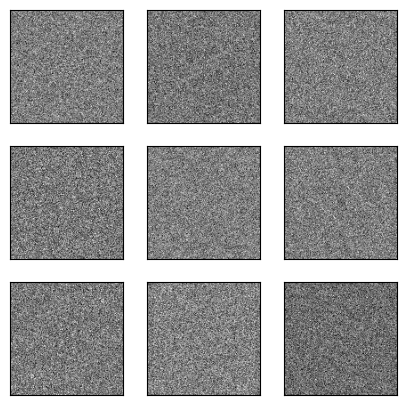

In [9]:
# First load the data and see how some of it looks
particle_reader = RelionParticleStackDataset(parameter_reader)

# check first 9 images
image_batch = particle_reader[0:9].images
print(parameter_reader)
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(image_batch[idx, :], cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
#plt.savefig(f"figures/noised_images", dpi=300)

# Save a numpy file to disk if needed

In [10]:
#jnp.save(base_directory + "calhm2_low_snr_images.npz", particle_reader[:].images)


# Put everything in a dataloader that can be batched up for likelihoods
Below i've set the batch size to the size of the dataset, may need to adjust!

In [11]:
# Now, put it in a dataloader
dataloader = jdl.DataLoader(
    utils.CustomJaxDataset(
        particle_reader
    ),  # Can be a jdl.Dataset or pytorch or huggingface or tensorflow dataset
    backend="jax",  # Use 'jax' backend for loading data
    batch_size=config["number_of_images"],  # Batch size
    shuffle=False,  # Shuffle the dataloader every iteration or not
    drop_last=False,  # Drop the last batch or not
)

# Compute Image-structure likelihoods
This returns a matrix where the entires are $log p(y_i | x_m)$ for image $y_i$ and stucture $x_m$

NOTE: these likelihoods have ground truth knowledge of pose, params, variance, noise, etc, its using the same imaging args and params as the generated images!


In [12]:
log_likelihood = ll.compute_likelihood_matrix_with_lax_map(
    dataloader,
    args = (imaging_args["potentials"], 
        imaging_args["potential_integrator"], 
        noise_variance),
    batch_size_potentials=1,
    batch_size_images=100,
)
jnp.save("log_likelihood.npy", log_likelihood)

# Estimate the populations of each image class
### NOTE: the example here is known to be an example where the structures are close enough that the ensemble reweighting optimization will "overfit" with too many iterations, if snr is set low enough above. this is a big TBD as far as cases to handle with these sorts of approaches

The "ensemble reweighting" here is from the "multiplicative gradient" function implemented [here](https://github.com/Quantitative-Heterogeneity/cryo_reweighting/blob/main/src/cryo_reweighting/optimization.py)


exiting at 24 iterations
[0.21919137 0.78080857]


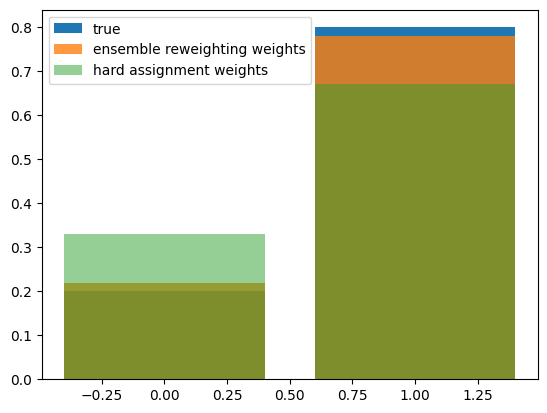

In [13]:
# # Estimate the populations of each image class
nodes = jnp.array([0, 1])

# get hard classification stuff, and its estimated populations
x = jnp.argmax(log_likelihood, axis = 1)

hard_weights = jnp.array([jnp.mean(x==0), jnp.mean(x==1)])
hard_weights /= jnp.sum(hard_weights)

# get soft classification stuff, and its estimated populations
soft_weights = optimization.multiplicative_gradient(log_likelihood, max_iterations=1)

# get ensemble reweighting stuff (here is where some messing with hyperparams like tol and max_iterations may be useful)
ensemble_weights,_  = optimization.multiplicative_gradient(log_likelihood)
print(ensemble_weights)
plt.figure()
plt.bar(nodes, true_weights, label='true', color="C0")
plt.bar(nodes, ensemble_weights, label='ensemble reweighting weights', color="C1", alpha=0.8)
plt.bar(nodes, hard_weights,label='hard assignment weights', color="C2", alpha=0.5)
#plt.bar(nodes, soft_weights/dx, 
#        width=dx, label='soft assignment weights', color="C3", alpha=0.5)
plt.legend()
plt.savefig("figures/weights.png")



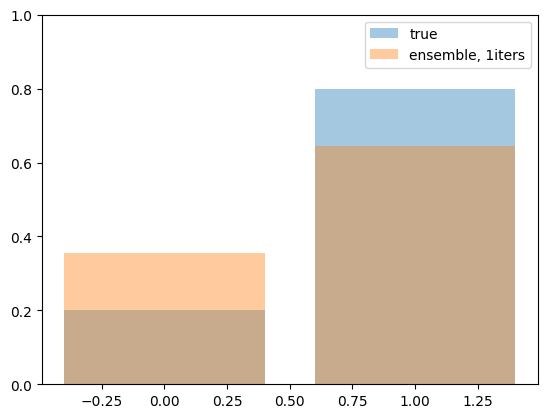

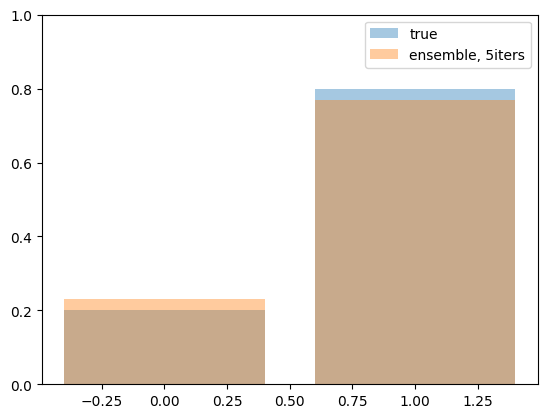

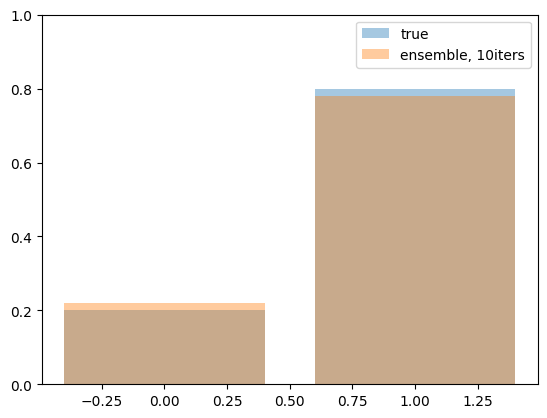

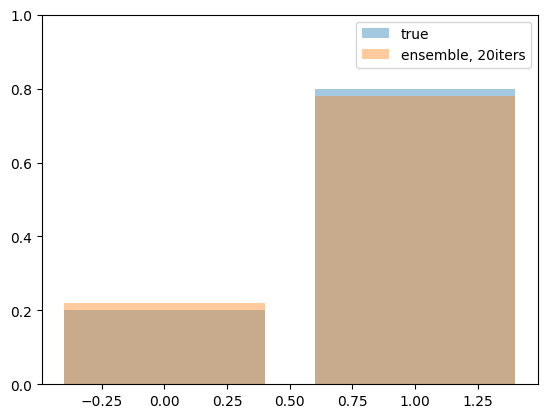

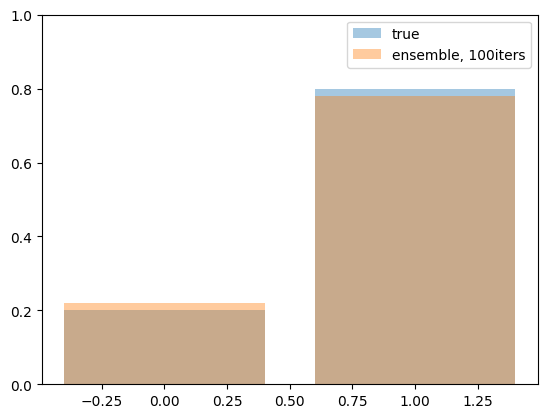

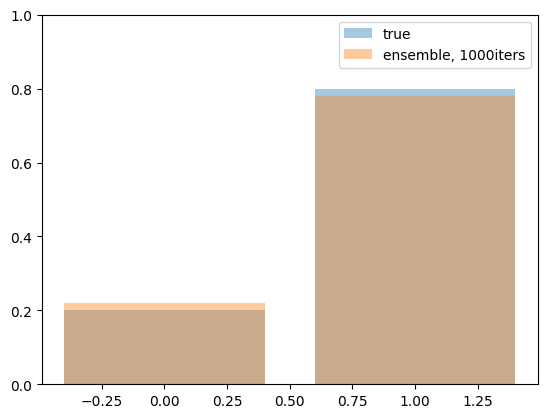

In [19]:
# %%
num_iterations = [1, 5, 10, 20, 100, 1000] 
for iters in num_iterations:
    plt.figure()
    plt.bar(nodes, true_weights, alpha=0.4, label=f"true", color="C0")
    ensemble_weights, _ = optimization.multiplicative_gradient(log_likelihood, tol=-1, max_iterations=iters)
    plt.bar(nodes, ensemble_weights, alpha=0.4, label=f"ensemble, {iters}iters", color="C1")
    plt.ylim([0, 1])
    plt.legend()
    plt.savefig(f"figures/num_iters_{iters}")



### To investigate, setting "stopping tolerance" to -1, meaning it won't stop until it hits prescribed number of maximum iterations

In [ ]:
num_iterations = [1, 5, 10, 20, 100, 1000] 
for iters in num_iterations:
    plt.figure()
    plt.plot(nodes, true_weights, label='true', color="C0")
    ensemble_weights = optimization.multiplicative_gradient(log_likelihood, tol=-1, max_iterations=iters)
    plt.bar(nodes, ensemble_weights/dx, 
            width=dx, alpha=0.4, label=f"ensemble, {iters}iters")
    plt.legend()


: 

## Exercise for the reader: output the loss at various iterations above